In [16]:
import os
import csv
import shutil
import random

In [14]:
directoryone = "daps_Data\\Class_One\\Spectrograms"
directorytwo = "daps_Data\\Class_Two\\Spectrograms"
for filename in os.listdir(directoryone):
    if 'f10' in filename:
        fullpath = os.path.join(directoryone, filename)
        shutil.move(fullpath, directorytwo)

In [18]:
test_directory = "daps_Data\\test_dataset\\Images"
training_directory = "daps_Data\\training_dataset\\Images"
directoryone = "daps_Data\\Class_One\\Spectrograms"
directorytwo = "daps_Data\\Class_Two\\Spectrograms"
i = 1
a = random.sample(range(1, 1968), 300)
for filename in os.listdir(directoryone):
    fullpath = os.path.join(directoryone, filename)
    if i in a:
        shutil.copy(fullpath, test_directory)        
    else:
        shutil.copy(fullpath, training_directory)
    i=i+1
i=1
a = random.sample(range(1, 4464), 700)
for filename in os.listdir(directorytwo):
    fullpath = os.path.join(directorytwo, filename)
    if i in a:
        shutil.copy(fullpath, test_directory)        
    else:
        shutil.copy(fullpath, training_directory)
    i=i+1

In [22]:
# name of csv file
csvname = "daps_Data\\training_dataset\\labels.csv"
class_one_indicators = ['f1', 'f7', 'f8', 'm3', 'm6', 'm8']
directory = "daps_Data\\training_dataset\\images"
# writing to csv file
with open(csvname, 'w') as csvfile:
    # creating a csv writer object
    csvwriter = csv.writer(csvfile)
    for filename in os.listdir(directory):
        if any(indicator in filename for indicator in class_one_indicators) and not 'f10' in filename:
            csvwriter.writerow([filename, '1'])
        else:
            csvwriter.writerow([filename, '0'])        

In [34]:
from PIL import Image
training_directory = "daps_Data\\training_dataset\\Images"
left = 125
top = 60
right = 901
bottom = 446
target = "daps_Data\\training_dataset\\Images_cropped\\"
# Opens a image in RGB mode
for filename in os.listdir(training_directory):
    fullpath = os.path.join(training_directory, filename)
    im = Image.open(fullpath)
 
# Size of the image in pixels (size of original image)
# (This is not mandatory)
# width, height = im.size
 
# Setting the points for cropped image

 
# Cropped image of above dimension
# (It will not change original image)
    im1 = im.crop((left, top, right, bottom))
    im1.save(target + filename)
# Shows the image in image viewer


In [29]:
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [30]:
class ImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [17]:
import torch
import torchvision
import torchvision.transforms.v2
import torchvision.transforms as transforms

In [31]:
transform = torchvision.transforms.v2.Compose([transforms.v2.ToImage(), transforms.v2.ToDtype(torch.float32, scale=True),\
                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = ImageDataset(annotations_file = "..\\work_folder\\daps_Data\\training_dataset\\labels.csv", img_dir = "..\\work_folder\\daps_Data\\training_dataset\\Images_cropped"\
                       , transform = transform)

testset = ImageDataset(annotations_file = "..\\work_folder\\daps_Data\\test_dataset\\labels.csv", img_dir = "..\\work_folder\\daps_Data\\test_dataset\\Images_cropped"\
                      , transform = transform)

In [32]:
batch_size = 4

trainloader = DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testloader = DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

classes = ("0", "1")

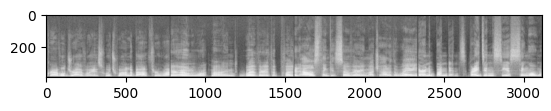

0     0     0     0    


In [33]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [34]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(284208, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=284208, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [35]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

In [36]:
PATH = '../work_folder/model_1.pth'

In [ ]:
torch.save(net.state_dict(), PATH)

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [37]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [ ]:
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

In [38]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 1000 test images: {100 * correct // total} %')

Accuracy of the network on the 1000 test images: 82 %


In [39]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: 0     is 89.3 %
Accuracy for class: 1     is 68.3 %
